In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### Load the data

In [2]:
gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits') # galaxies data
samples = Table.read('../fits/SF_fits/samples.fits') # galaxy samples data
mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')

In [3]:
sparcfire_g = Table.read('../sparcfire_directories/main/sparcfire_g_matched.fits') # sparcfire data

In [4]:
sparcfire_g_arcs = pd.read_csv('../sparcfire_directories/g/g.galaxy_arcs.csv') # individual arc data

#### Now create our samples, using masks

In [5]:
# Look for spirals (Hart+17 method), which have been successfully reduced in sparcfire
in_spiral = np.all([mendel_masses['in_mass_limit'],samples['in_spiral'],samples['axial_ok']],
                   axis=0)
in_sparcfire = sparcfire_g['fit_state'] == 'OK'
sparcfire_spirals = np.all([in_spiral,in_sparcfire],axis=0)

# Convert sparcfire chiralitites to binary values (for fast lookup)
id_column = np.array(sparcfire_g['name']).astype(np.int64)
chirality_column = np.array(sparcfire_g['chirality_wtdPangSum'] == 'S-wise').astype(np.int)
chi_array = np.array([id_column,chirality_column]).T

In [6]:
def measure_weighted_average(data,columns):
    p_array = np.array([data[c] for c in columns]).T
    p_array[np.isfinite(p_array) == False] = 0
    p_mean = np.zeros(len(p_array))
    p_sum = np.sum(p_array,axis=1)
    for c in range(len(columns)):
        p_mean += (c+1)*p_array[:,c]
    p_mean = p_mean/p_sum
    p_mean[np.isfinite(p_mean) == False] = 0
    p_absolute = np.argmax(p_array,axis=1) + 1
    return p_mean, p_absolute

m_columns = ['t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh']

w_columns =  ['t10_arms_winding_a28_tight_debiased_rh',
              't10_arms_winding_a29_medium_debiased_rh',
              't10_arms_winding_a30_loose_debiased_rh']

m_wtd_average, m_absolute = measure_weighted_average(gz_data,m_columns)
w_wtd_average, w_absolute = measure_weighted_average(gz_data,w_columns)
gz_statistics = Table(np.array([m_wtd_average,m_absolute,w_wtd_average,w_absolute]).T,
                      names=('m_wtd_avg','m','w_wtd_avg','w'),
                      dtype=(float,int,float,int))

spiral_statistics = gz_statistics[sparcfire_spirals]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


#### In bins of $m_\mathrm{wtd \, avg}$, at what length should we cut the data?
1. Using a _single_ length cut?
2. Investigate a _variable_ length cut?
3. Compare pitch angles?

#### Considerations:
- log space (ie. effectively 'downweighting' the top end)
- $N$ or $N_\mathrm{wtd \, avg}$

In [7]:
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit
from lookup_arcs import ArcLookup, ArcStats # my class for measuring arc statistics
from xy_plots import x_vs_y # my class for binning and plotting
from bin_statistics import assign_bins # my binning class

colors = 'bgyrmk'

In [8]:
# Here, we'll get all of the individual arc data into rows to map onto gz_data

ids = sparcfire_g['dr8objid'][sparcfire_spirals]

arc_table = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),
                  dtype=(int,int,object,object,object,object,object))

for id_ in ids:
    a = ArcLookup(id_)
    chi = a.chirality(chi_array)
    arc_list = a.arc_list(sparcfire_g_arcs,chi)
    arc_table.add_row(arc_list)
    
arc_table_all = Table(np.zeros((len(gz_data),7)),
                      names=('id','N','P','L','intensity','N_pixels','L_f'),
                      dtype=(int,int,object,object,object,object,object))
arc_table_all[sparcfire_spirals] = arc_table

/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(3075, 20) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(3075, 40) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(3075, 60) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(3075, 80) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


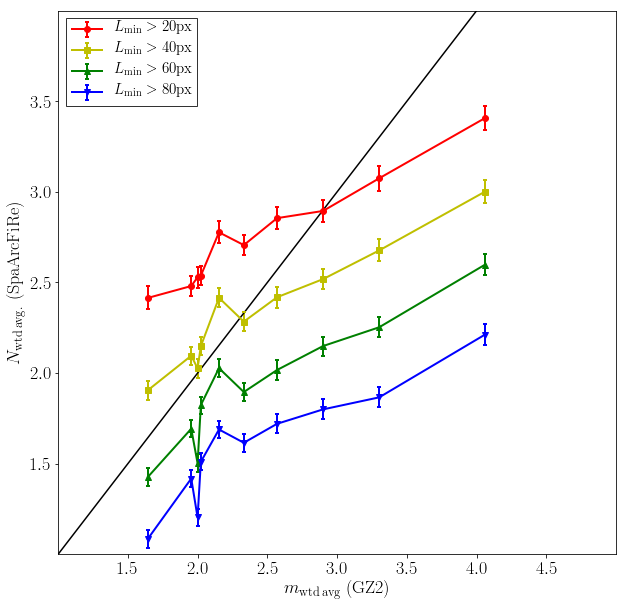

In [38]:
from xy_plots import x_vs_y
from lookup_arcs import ArcLookup, ArcStats
colors = 'rygb'
markers = 'os^v'

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

x = spiral_statistics['m_wtd_avg']
ax.plot([0,10],[0,10],color='k')
ax.set_xlim(1,5)
ax.set_ylim(1,4)

ax.set_ylabel('$N_\mathrm{wtd \, avg.}$ (SpaArcFiRe)')
ax.set_xlabel('$m_\mathrm{wtd \, avg}$ (GZ2)')

for p, px_min in enumerate([20,40,60,80]):
    y_p = ArcStats(arc_table).N_weighted_average(px_min)
    labelstring = '$L_\mathrm{{min}}>{}\mathrm{{px}}$'.format(px_min)
    _ = x_vs_y(x,y_p).continuous_vs_continuous_binned(ax,bins=10,color=colors[p],marker=markers[p],
                                                      capsize=2,lw=2,capthick=2,label=labelstring,
                                                      equal_N=True)

ax.legend(loc='upper left',fontsize=15,
          edgecolor='k',fancybox=False)

fig.savefig('figures/m_vs_N_all.pdf')

#### To at least test whether a fit to the data is reasonable, we will do the most basic possible fit (linear)

---> This should _at least_ be able to fit the data slightly better, ie. go the right way

### Now do the same for a series of fixed cuts
- This is essentially what we plot in the 4 panel plots with 4 colours above, but for a more continuous range.

In [16]:
# Here, we are simply going over a range of possible L cuts (20-100) and find the best agreement in each case

def measure_chi(x,y,logged=False,log=False):
    if (logged is False) and (log is True):
        x, y = np.log10(x), np.log10(y)    
    elif (logged is True) and (log is False):
        x, y = 10**(x), 10**(y)
    ok = ((np.all([np.isfinite(x),np.isfinite(y)],axis=0) if log is True 
          else np.all([x>0,y>0],axis=0)))
    
    absolute_chi = np.absolute(x[ok]-y[ok])
    chi_mean = np.mean(absolute_chi)
    return chi_mean

def find_best_px(x,function,pxs=np.linspace(20,100,81),log=False,
                 return_values=False):
    chi_array = np.empty(pxs.size)
    for p, px in enumerate(pxs):
        y = function(px)
        chi = measure_chi(x,y,log=log)
        chi_array[p] = chi
    best_index = chi_array.argmin()
    best_px = pxs[best_index]
    if return_values is True:
        return pxs, chi_array
    else:
        return best_px
    
x = spiral_statistics['m_wtd_avg']
px, chi = find_best_px(x,ArcStats(arc_table).N_weighted_average,return_values=True)
px_absolute = find_best_px(x,ArcStats(arc_table).N_weighted_average)

0.755252335692


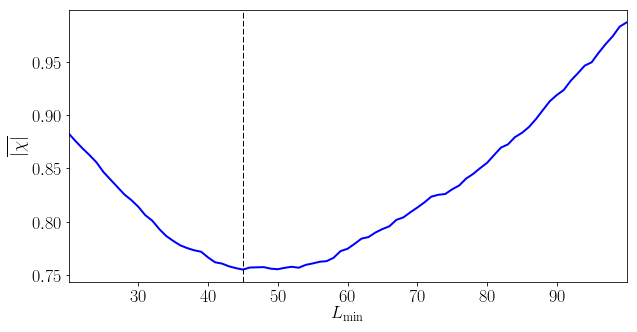

In [39]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim(20,100)

_ = plt.plot(px,chi,color='b',lw=2)
_ = plt.axvline(px_absolute,color='k',lw=1,linestyle='dashed')
ax.set_xlabel('$L_\mathrm{min}$')
ax.set_ylabel('$\overline{|\chi|}$')

fig.savefig('figures/measure_best_chi.pdf')

print(chi.min())

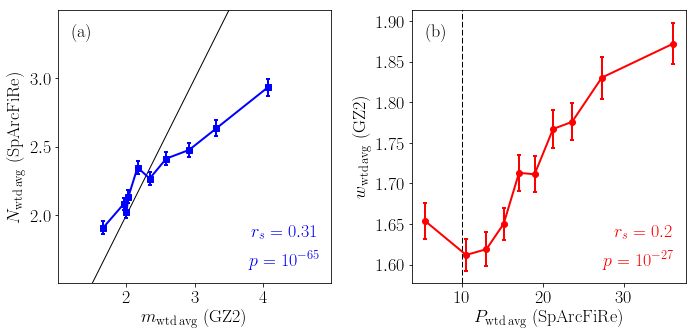

In [36]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
ax.plot([1,5],[1,5],color='k',lw=1)
x0 = spiral_statistics['m_wtd_avg']
y0 = ArcStats(arc_table).N_weighted_average(px_absolute)
ok_xy = np.all([x0>0,y0>0],axis=0)
xy = x_vs_y(x0[ok_xy],y0[ok_xy])
xy.continuous_vs_continuous_binned(ax,bins=10,equal_N=True,color='b',
                                   marker='s',capsize=2,capthick=2,
                                   lw=2)
xy.show_spearmanr(ax,location='lower right',color='b')
ax.set_xlim(1,5)
ax.set_ylim(1.5,3.5)
ax.set_xlabel('$m_\mathrm{wtd \, avg}$ (GZ2)')
ax.set_ylabel('$N_\mathrm{wtd \, avg}$ (SpArcFiRe)')
ax.text(0.05,0.95,'(a)',
        ha='left',va='top',transform=ax.transAxes)

ax = axarr[1]
plt.sca(ax)
plt.axvline(10,color='k',linestyle='dashed',lw=1)
x1 = ArcStats(arc_table).P_average(px_absolute)
y1 = spiral_statistics['w_wtd_avg']

ok_xy = np.all([x1>0,y1>0],axis=0)
xy = x_vs_y(x1[ok_xy],y1[ok_xy])
xy.continuous_vs_continuous_binned(ax,bins=10,equal_N=True,color='r',
                                   marker='o',capsize=2,capthick=2,
                                   lw=2)
xy.show_spearmanr(ax,location='lower right',color='r')
ax.set_xlabel('$P_\mathrm{wtd \, avg}$ (SpArcFiRe)')
ax.set_ylabel('$w_\mathrm{wtd \, avg}$ (GZ2)')
ax.text(0.05,0.95,'(b)',
        ha='left',va='top',transform=ax.transAxes)

fig.tight_layout()
fig.savefig('figures/m_vs_N_and_P_vs_w.pdf')

### Now the final check: does w_wtd_avg correlate with P?

### In conclusion:
- The $N_\mathrm{wtd \, avg}$ technique is preferred over the $N$ statistic (it is a more consistent predictor of $m_\mathrm{wtd \, avg}$)
- There is, if _anything_ only tiny gain from doing a sophisticated variable $L_{min}$ method.

---> .'., we'll apply a single length cut to $N_\mathrm{wtd \, avg}$ (suggested cut= 45 pixels)

In [96]:
pitch_angles = Table()
P = np.ones(len(gz_data))*-999
N = np.ones(len(gz_data))*-999
P[sparcfire_spirals] = ArcStats(arc_table).P_average(px_absolute)
N[sparcfire_spirals] = ArcStats(arc_table).N_weighted_average(px_absolute)

pitch_angles['N'] = N
pitch_angles['P'] = P
pitch_angles['in_sparcfire'] = in_sparcfire
pitch_angles['m'] = gz_statistics['m']
pitch_angles['m_wtd_avg'] = gz_statistics['m_wtd_avg']
pitch_angles['w'] = gz_statistics['w']
pitch_angles['w_wtd_avg'] = gz_statistics['w_wtd_avg']
pitch_angles['chi_sparcfire'] = chirality_column

pitch_angles.write('../fits/sparcfire/pitch_angles.fits',overwrite=True)

In [97]:
### Now, output the individual arc data:

def output_arrays(arc_table_all,L_min=None):
    colnames = ['P','L','intensity','L_f']
    def make_column(colname,rows,N_arcs):
        output_array = base_array.copy()
        input_data = arc_table_all[colname]
        for r in rows:
            N_arcs_r = N_arcs[r]
            output_array[r,:N_arcs_r] = arc_table_all[colname][r]
        return output_array
    
    def mask_out_data(data,mask):
        data[mask == False] = -999 
        mask_out_columns = np.any(mask,axis=0)
        data_masked = (data.T[mask_out_columns]).T
        return data_masked
    
    N_rows = len(arc_table_all)
    mask = np.array([type(a) for a in arc_table_all['P']]) == list
    rows = np.arange(N_rows)[mask]
    
    N_arcs = np.zeros(N_rows,dtype=np.int)
    N_arcs[mask] = [len(a) for a in arc_table_all['P'][mask]]
    N_max = np.max(N_arcs).astype(int)
    base_array = np.ones((N_rows,N_max))*-999
    
    P_array = make_column('P',rows,N_arcs)
    L_array = make_column('L',rows,N_arcs)
    intensity_array = make_column('intensity',rows,N_arcs)
    L_f_array = make_column('L_f',rows,N_arcs)
    N_wtd_avg_start = np.cumsum(L_f_array,axis=1)
    
    if L_min is not None:
        mask = L_array > L_min
        P_array = mask_out_data(P_array,mask)
        L_array = mask_out_data(L_array,mask)
        intensity_array = mask_out_data(intensity_array,mask)
        L_f_array = mask_out_data(L_f_array,mask)
        N_wtd_avg_start = mask_out_data(N_wtd_avg_start,mask)
    
    return P_array, L_array, intensity_array, L_f_array, N_wtd_avg_start

In [98]:
P_array, L_array, intensity_array, L_f_array, N_wtd_avg_start = output_arrays(arc_table_all,L_min=45)

np.save('../fits/sparcfire/np_metadata/P.npy',P_array)
np.save('../fits/sparcfire/np_metadata/L.npy',L_array)
np.save('../fits/sparcfire/np_metadata/intensity.npy',intensity_array)
np.save('../fits/sparcfire/np_metadata/L_f.npy',L_f_array)
np.save('../fits/sparcfire/np_metadata/N_wtd_avg_start.npy',N_wtd_avg_start)